In [23]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
import random
# from plot_confusion_matrix import plot_confusion_matrix
from collections import defaultdict

import scipy.io
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
from itertools import product
# from scipy.stats import multivariate_normal as mvn
# import scipy.sparse.linalg as ll

In [2]:
### MNIST data set
# load data
data = scipy.io.loadmat('data/mnist_10digits.mat')
X_train, y_train, X_test, y_test = data['xtrain'], data['ytrain'].T, data['xtest'], data['ytest'].T
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 784) (60000, 1) (10000, 784) (10000, 1)


In [3]:
y_train = y_train[:,0]
y_test = y_test[:,0]

In [4]:
# downsampling the training data
random.seed(1)
indices = random.sample(range(60000), 5000)
indices_median_trick = random.sample(range(60000), 1000)

# sample for median trick
X_sample = X_train[indices]/255

# downsampling the training data
X_train = X_train[indices]
y_train = y_train[indices]

# standardize the features
X_train = X_train/255
X_test = X_test/255

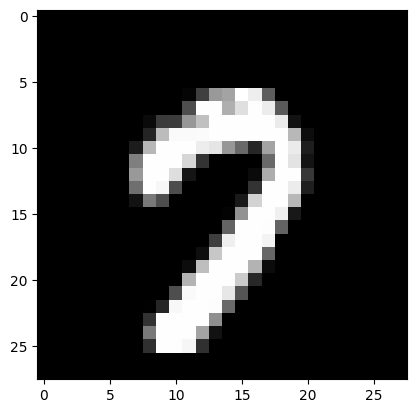

In [5]:
plt.imshow(X_train[0].reshape((28,28)), cmap = 'gray')

Text(0.5, 1.0, 'Distribution of y_train')

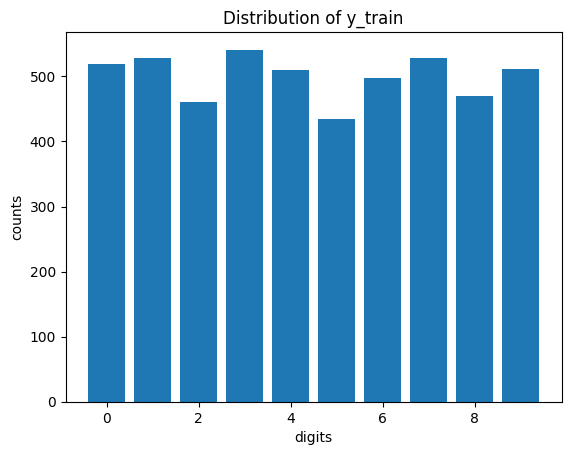

In [7]:
nums = [i for i in range(10)]
counts = []
for i in nums:
    counts.append(len(y_train[y_train == i]))
plt.bar(nums,counts)
plt.xlabel('digits')
plt.ylabel('counts')
plt.title('Distribution of y_train')


## KNN classifier

Tune the number of neighbors and the distance function in KNN

In [8]:
#List Hyperparameters that we want to tune.
n_neighbors = list(range(1,10))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best p: 2
Best n_neighbors: 5


In [9]:
knn = KNeighborsClassifier(n_neighbors=5, p=2)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

## Logistic Regression

Tune regularization parameter for Logistic Regression

In [10]:
#List Hyperparameters that we want to tune.
C = list(np.linspace(0.1,1,10))
penalty = ['l1','l2']
#Convert to dictionary
hyperparameters = dict(C=C)
#Create new SVM object
lr = LogisticRegression()
#Use GridSearch
clf = GridSearchCV(lr, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best penalty: l2
Best C: 0.1


In [11]:
lr = LogisticRegression(C = 0.2, penalty = 'l2')
lr.fit(X_train, y_train)

LogisticRegression(C=0.2)

## Linear Support Vector Machine

Tune regularization parameter for linear SVM

In [12]:
#List Hyperparameters that we want to tune.
C = list(np.linspace(0.1,1,10))
#Convert to dictionary
hyperparameters = dict(C=C)
#Create new SVM object
linearSVC = LinearSVC()
#Use GridSearch
clf = GridSearchCV(linearSVC, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters
print('Best penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best penalty: l2
Best C: 0.1


In [13]:
linearSVC = LinearSVC(C= 0.1)
linearSVC.fit(X_train,y_train)

LinearSVC(C=0.1)

## Kernel Support Vector Machine

$\gamma = \frac{1}{2 \sigma^2} = \frac{1}{M}$ where

$M$ = the median of $\{\|x^i - x^j\|^2, 1 \leq i,j \leq m', i \neq j \}$ with $m' = 1000$.

$$\|x^i - x^j\|^2 = \|x^i\|_2^2 - 2 <x^i, x^j> + \|x_j\|_2^2$$

In [14]:
M/2

NameError: name 'M' is not defined

In [15]:
# find M
P = X_sample @ X_sample.T
pairwise_distances = []
for i in range(1000):
    for j in range(i+1,1000):
        pairwise_distances.append(P[i,i] - 2 * P[i,j] + P[j,j])
M = np.median(np.array(pairwise_distances))

In [16]:
#List Hyperparameters that we want to tune.
C = list(range(1,15))
#Convert to dictionary
hyperparameters = dict(C=C)
#Create new SVM object
kernelSVC = SVC(kernel = 'rbf', gamma = 1/M)
#Use GridSearch
clf = GridSearchCV(kernelSVC, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train,y_train)
#Print The value of best Hyperparameters

print('Best C:', best_model.best_estimator_.get_params()['C'])

Best C: 12


In [17]:
kernelSVC = best_model.best_estimator_

## Neural Network

In [18]:
NN = MLPClassifier(hidden_layer_sizes = (20,10))  
NN.fit(X_train,y_train)
# y_pred = NN.predict(X_test)
# print(classification_report(y_test, y_pred))

MLPClassifier(hidden_layer_sizes=(20, 10))

In [19]:
predicts = {}

KNN classifier:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.88      1.00      0.94      1135
           2       0.98      0.89      0.93      1032
           3       0.92      0.95      0.93      1010
           4       0.95      0.90      0.92       982
           5       0.93      0.92      0.93       892
           6       0.96      0.97      0.96       958
           7       0.93      0.93      0.93      1028
           8       0.98      0.86      0.92       974
           9       0.89      0.92      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.94      0.93      0.93     10000

confusion matrix: 
[[ 970    1    0    1    0    1    6    1    0    0]
 [   0 1130    1    2    0    0    1    0    0    1]
 [  25   45  916    9    2    1    4   22    8    0]
 [   0    7    4  956    1   22    1    9    4 

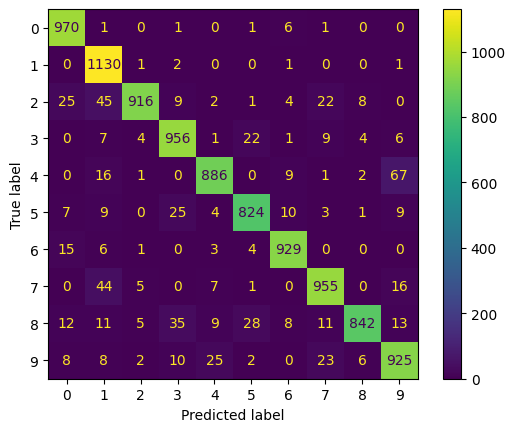

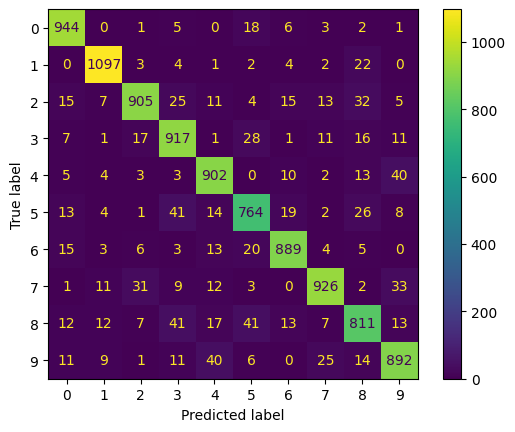

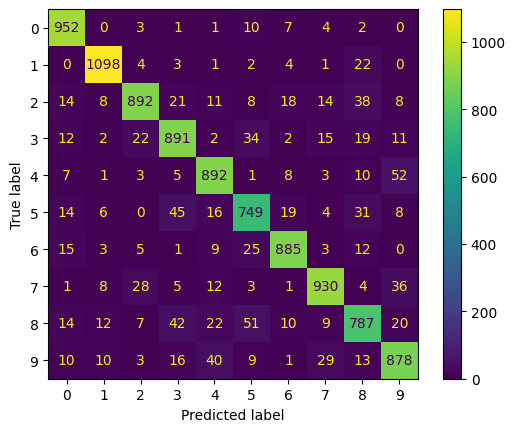

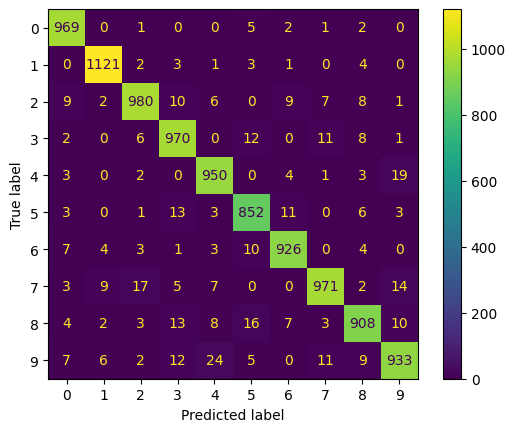

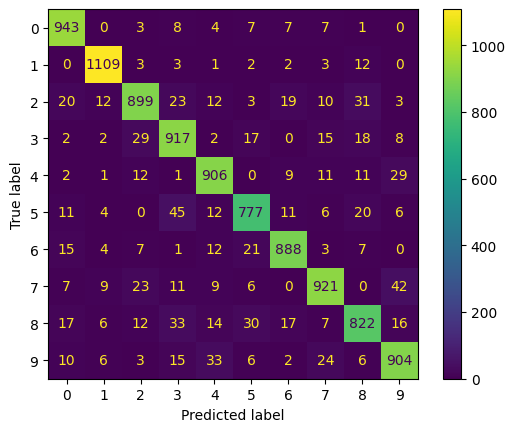

In [25]:
classifiers = { 'KNN classifier': knn,
        'Logistic Regressor': lr,
        'SVM': linearSVC,
        'Kernel SVM': kernelSVC,
        'Neural Networks': NN       
         }

for model_name in classifiers:
    model = classifiers[model_name]
    y_pred = model.predict(X_test)
    predicts[model_name] = y_pred
    print(model_name + ':')
    print(classification_report(y_test, y_pred))
    print('confusion matrix: ')
    print(confusion_matrix(y_test,y_pred))
    print('*****************************************************')
    # plot_confusion_matrix(confusion_matrix(y_test, y_pred), 
    #                   target_names = [i for i in range(10)],
    #                   fig_name = 'cm_' + model_name[:3] + '.jpg',
    #                   title = model_name + ' Confusion Matrix',
    #                   normalize= False
    #                  )
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clf.classes_).plot()

In [64]:
predicts

{'KNN classifier': array([7, 2, 1, ..., 4, 5, 6]),
 'Logistic Regressor': array([7, 2, 1, ..., 4, 5, 6]),
 'SVM': array([7, 2, 1, ..., 4, 5, 6]),
 'Kernel SVM': array([7, 2, 1, ..., 4, 5, 6]),
 'Neural Networks': array([7, 2, 1, ..., 4, 5, 6])}

In [142]:
def print_report(y_pred):
    for i in range(10):
        tp = len(y_pred[(y_pred == i) & (y_test == i)]) 
        precision = tp / sum(y_pred == i)
        recall = tp / sum(y_test == i)
        f1 = 2 * precision * recall / (precision + recall)
        print('i = {0}, precision = {1}, recall = {2}, f1 = {3}'.format(i, round(precision,2), round(recall,2), round(f1,2)))

In [143]:
precisions = defaultdict(list)
recalls = defaultdict(list)
f1s = defaultdict(list)

# compute precision, recall and f1 for each model and each class
for model_name in predicts:
    # get predictions
    y_pred = predicts[model_name]
    for i in range(10):
        # compute true positive counts
        tp = len(y_pred[(y_pred == i) & (y_test == i)]) 
        
        precision = tp / sum(y_pred == i)
        recall = tp / sum(y_test == i)
        f1 = 2 * precision * recall / (precision + recall)
        
        # round the results to 2 decimals 
        precision = round(precision,2)
        recall = round(recall,2)
        f1 = round(f1,2)
        
        # save the results to dictionaries
        precisions[model_name].append(precision)
        recalls[model_name].append(recall)
        f1s[model_name].append(f1)

In [144]:
# plot the results
def plot_metrics(metrics, title):
    'metrics: can be the dictionaries precisions, recalls, and f1s'
    plt.figure(figsize = (8,6))
    for model_name in metrics:
        plt.plot(metrics[model_name], '-*', label = model_name)
    
    plt.title(title)
    plt.xlabel('classes')
    plt.ylabel(title)
    plt.legend()
    plt.savefig('../Latex/images/' + title + '.jpg')
    plt.show

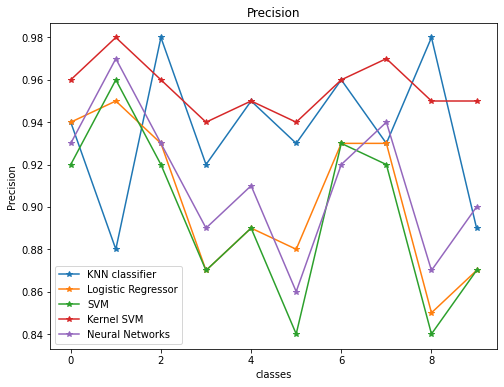

In [145]:
plot_metrics(precisions, 'Precision')

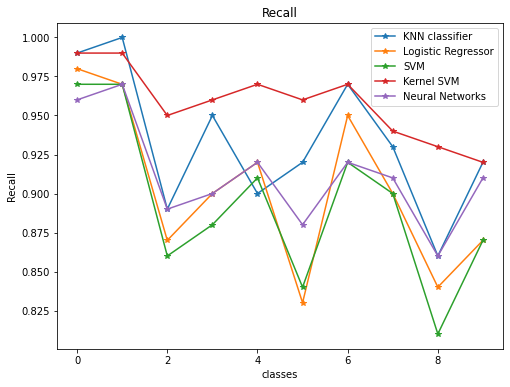

In [146]:
plot_metrics(recalls, 'Recall')

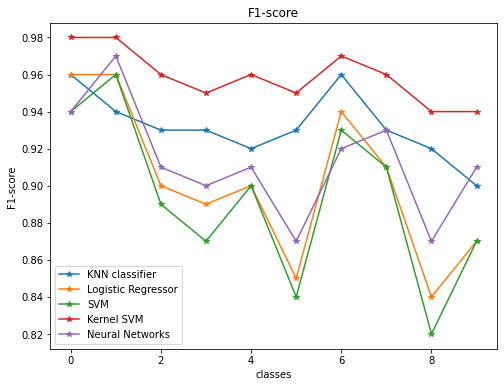

In [147]:
plot_metrics(f1s, 'F1-score')

In [148]:
# print latex code
def print_latex(metrics):
    'metrics: precisions, recalls, f1s'
    for model_name in metrics:
        print(model_name, end = '') 
        for i in range(10):
            print(' & ', metrics[model_name][i], end = '')
        print(' \\\\')
        print('\hline')

In [149]:
print_latex(precisions)

KNN classifier &  0.94 &  0.88 &  0.98 &  0.92 &  0.95 &  0.93 &  0.96 &  0.93 &  0.98 &  0.89 \\
\hline
Logistic Regressor &  0.94 &  0.95 &  0.93 &  0.87 &  0.89 &  0.88 &  0.93 &  0.93 &  0.85 &  0.87 \\
\hline
SVM &  0.92 &  0.96 &  0.92 &  0.87 &  0.89 &  0.84 &  0.93 &  0.92 &  0.84 &  0.87 \\
\hline
Kernel SVM &  0.96 &  0.98 &  0.96 &  0.94 &  0.95 &  0.94 &  0.96 &  0.97 &  0.95 &  0.95 \\
\hline
Neural Networks &  0.93 &  0.97 &  0.93 &  0.89 &  0.91 &  0.86 &  0.92 &  0.94 &  0.87 &  0.9 \\
\hline


In [150]:
print_latex(recalls)

KNN classifier &  0.99 &  1.0 &  0.89 &  0.95 &  0.9 &  0.92 &  0.97 &  0.93 &  0.86 &  0.92 \\
\hline
Logistic Regressor &  0.98 &  0.97 &  0.87 &  0.9 &  0.92 &  0.83 &  0.95 &  0.9 &  0.84 &  0.87 \\
\hline
SVM &  0.97 &  0.97 &  0.86 &  0.88 &  0.91 &  0.84 &  0.92 &  0.9 &  0.81 &  0.87 \\
\hline
Kernel SVM &  0.99 &  0.99 &  0.95 &  0.96 &  0.97 &  0.96 &  0.97 &  0.94 &  0.93 &  0.92 \\
\hline
Neural Networks &  0.96 &  0.97 &  0.89 &  0.9 &  0.92 &  0.88 &  0.92 &  0.91 &  0.86 &  0.91 \\
\hline


In [151]:
print_latex(f1s)

KNN classifier &  0.96 &  0.94 &  0.93 &  0.93 &  0.92 &  0.93 &  0.96 &  0.93 &  0.92 &  0.9 \\
\hline
Logistic Regressor &  0.96 &  0.96 &  0.9 &  0.89 &  0.9 &  0.85 &  0.94 &  0.91 &  0.84 &  0.87 \\
\hline
SVM &  0.94 &  0.96 &  0.89 &  0.87 &  0.9 &  0.84 &  0.93 &  0.91 &  0.82 &  0.87 \\
\hline
Kernel SVM &  0.98 &  0.98 &  0.96 &  0.95 &  0.96 &  0.95 &  0.97 &  0.96 &  0.94 &  0.94 \\
\hline
Neural Networks &  0.94 &  0.97 &  0.91 &  0.9 &  0.91 &  0.87 &  0.92 &  0.93 &  0.87 &  0.91 \\
\hline


In [92]:
for model_name in recalls:
    print('\includegraphics[width=0.8\\textwidth]' + '{images/cm_' + model_name[:3] + '.jpg}')

\includegraphics[width=0.8\textwidth]{images/cm_KNN.jpg}
\includegraphics[width=0.8\textwidth]{images/cm_Log.jpg}
\includegraphics[width=0.8\textwidth]{images/cm_SVM.jpg}
\includegraphics[width=0.8\textwidth]{images/cm_Ker.jpg}
\includegraphics[width=0.8\textwidth]{images/cm_Neu.jpg}
